In [1]:
# Yakov Berchenko-Kogan
# Code accompanying "Numerically Computing the Index of
# Mean Curvature Flow Self-Shrinkers"

In [2]:
import sympy as sy
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

sy.init_printing()
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=11)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']

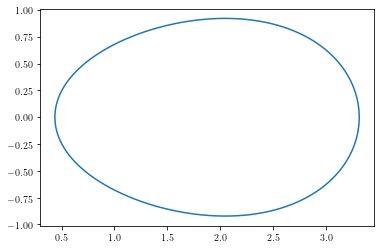

In [3]:
# Load the previously computed cross-section of the Angenent torus
# with 2048 points.
curve = np.load('angenent2048.npy')
M = len(curve)
plt.plot(*curve.T)

In [4]:
kmax = 4 # We will compute L_k for k < kmax.

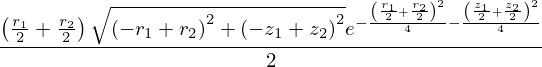

In [5]:
# Symbolically compute the discrete distance and its Hessian.
r, z, r1, z1, r2, z2 = sy.symbols('r z r1 z1 r2 z2')

conformalFactor = r / 2 * sy.exp(-(r**2 + z**2)/4)

# Evaluate the conformal factor at the midpoint and
# multiply by the Euclidean distance.
discreteDistanceSymbolic = conformalFactor.subs(
    [(r, (r1+r2)/2), (z, (z1+z2)/2)]
) * sy.sqrt((r2-r1)**2 + (z2-z1)**2)

# Compute the Hessian of the discrete distance.
hessSymbolic = sy.hessian(discreteDistanceSymbolic, (r1, z1, r2, z2))

# Create fast functions to compute the symbolic expressions.
discreteDistance = sy.lambdify((r1, z1, r2, z2), discreteDistanceSymbolic)
hess = sy.lambdify((r1, z1, r2, z2), hessSymbolic)

discreteDistanceSymbolic

In [6]:
# Compute the length of the cross-section with respect to the weighted metric.
# This length is the entropy of the Angenent torus.
length = 0
for m in range(M) :
    length += discreteDistance(*curve[m-1], *curve[m])
length

In [7]:
%%time
# hessians[m] is the Hessian of the discrete distance, evaluated at
# (q_m, q_{m+1}). This quantity is denoted H_{m, m+1} in the paper.
hessians = np.empty((M, 4, 4))
for m in range(M) :
    hessians[m] = hess(*curve[m], *curve[(m+1) % M])

CPU times: user 1.63 s, sys: 9.72 ms, total: 1.64 s
Wall time: 1.61 s


In [8]:
# normals[m] is the normal vector to the curve at q_m.
# This quantity is denoted \mathbf{n}_m in the paper.
normals = np.empty((M, 2))
for m in range(M) :
    Hm = hessians[m-1, 2:, 2:] + hessians[m, :2, :2] # The matrix H_m.
    _, vs = np.linalg.eigh(Hm)
    normals[m] = vs[1]

    #Ensure outward pointing normals.
    tangent = curve[(m+1) % M] - curve[m-1]
    if np.cross(normals[m], tangent) < 0:
        normals[m] *= -1

In [9]:
# L0 is -L_{0; d} in the paper.
L0 = np.zeros((M,M))
for m in range(M) :
    # NT is \mathbf{N}_{m, m+1}^T in the paper.
    NT = sc.linalg.block_diag(normals[m], normals[(m+1) % M])
    # L0m is -L_{0; m, m+1} in the paper.
    L0m = M / length * NT.dot(hessians[m]).dot(NT.T)
    for i in range(2) :
        for j in range(2) :
            L0[(m+i) % M, (m+j) % M] += L0m[i, j]

In [10]:
# Lks[k] is -L_{k; d} in the paper.
Lks = np.empty((kmax, M, M))
# Rn2 is the diagonal matrix with entries r_m^{-2}, denoted R_d^{-2} in the paper.
Rn2 = np.diag(curve[:, 0]**(-2)) 
for k in range(kmax) :
    Lks[k] = L0 + k**2 * Rn2 # L0 + k^2/r^2

In [11]:
%%time
# eks[k] and uks[k] are the eigenvalues and eigenvectors of -L_{k; d}.
eks = np.empty((kmax, M))
uks = np.empty((kmax, M, M))
for k in range(kmax) :
    eks[k], uks[k] = np.linalg.eigh(Lks[k])

CPU times: user 12.6 s, sys: 211 ms, total: 12.8 s
Wall time: 2.14 s


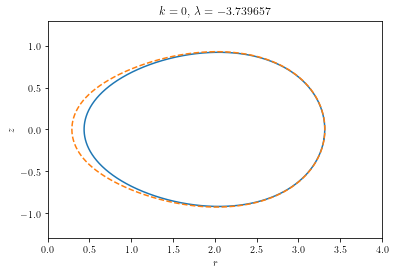

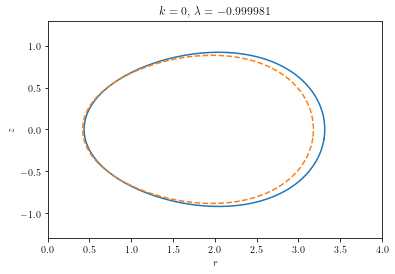

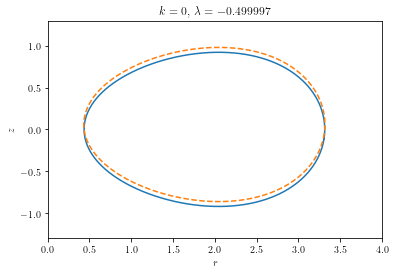

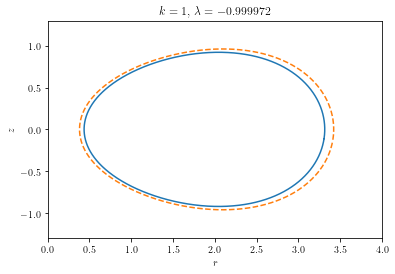

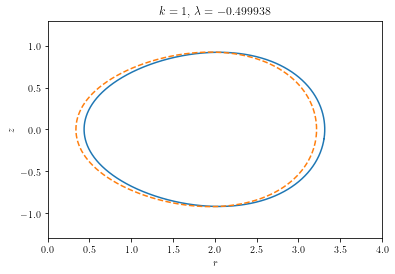

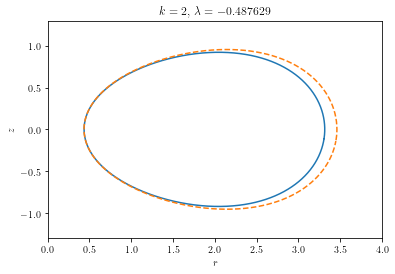

In [12]:
def plotCurveVariation(k, j) :
    variation = uks[k, :, j] # u_m.
    normalVariation = variation[:, np.newaxis] * normals # u_m \mathbf{n}_m.
    # Scaling factor for the eigenvectors so the plots look nice.
    variationScaling = -.05 * np.sqrt(M)
    
    plt.plot(*curve.T)
    plt.plot(*(curve + variationScaling * normalVariation).T, '--')    
    plt.title('$k={}$, $\lambda={:f}$'.format(k, eks[k, j]))
    plt.xlabel('$r$')
    plt.ylabel('$z$')
    plt.gca().set_aspect('equal', 'box')
    plt.xlim((0, 4))
    plt.ylim((-1.3, 1.3))

for k in range(kmax) :
    for j in range(M) :
        if eks[k, j] < 0 :
            plotCurveVariation(k, j)
            plt.show()